In [1]:
# importar bibliotecas
import pandas as pd
import numpy as np
import os
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout
import time
# %matplotlib inline

In [2]:
# Verifica a pasta corrente
pasta = os.getcwd()

In [3]:
# Junta caminho corrente + pasta com os arquivos "ambos", "homens", "mulheres"
pasta_ambos = os.path.join(pasta, "ambos")
pasta_mulheres = os.path.join(pasta, "mulheres")
pasta_homens = os.path.join(pasta, "homens")

In [4]:
# Lista arquivos das pastas
arquivos_ambos = os.listdir(pasta_ambos)
arquivos_mulheres = os.listdir(pasta_mulheres)
arquivos_homens = os.listdir(pasta_homens)

In [5]:
# Lista os arquivos somente excel e que comecem com 'ambos', 'homens', 'mulheres'
arq_ambos_xls = [arq_ambos for arq_ambos in arquivos_ambos if arq_ambos[-3:]=='xls']
arq_mulher_xls = [arq_mulher for arq_mulher in arquivos_mulheres if arq_mulher[-3:]=='xls']
arq_homem_xls = [arq_homem for arq_homem in arquivos_homens if arq_homem[-3:]=='xls']

Obs.:
> Pula_linhas: Existe um modelo em todos os arquivos. Não imprimir algumas linhas
> assign(arq), para gravar o ano da tabela no dataframe
#### colunas:
1. x: idade da pessoa
2. qx_mil: probabilidade de morte entre duas idades exatas na idade x;
3. dx: número de mortos na idade x;
4. lx: número de vivos na idade x;
5. Lx: Pessoas vivas na metade da idade x;
6. Tx: Quantidade de existencia na idade x. Representa o somatório dos anos vividos pelas pessoas componentes de um grupo de idade x até o instante de sua extinção. Em outras palavras, é o acompanhamento, ano a ano, de um grupo até sua extinção;
7. Ex: Expectativa de vida na idade x.
8. qx: probabilidade de morte na idade x. corresponde qx_mil/1000

### Tratamento de inconsistencias na importação

In [6]:
# Pular linhas na leitura dos arquivos
pular_linhas1 = list(range(0,5)) + list(range(46,62)) + list(range(103,113))
pular_linhas2 = list(range(0,5)) + list(range(46,61)) + list(range(102,113))
pular_linhas3 = list(range(0,4)) + list(range(45,61)) + list(range(102,113))

In [7]:
colunas = ['x', 'qx_mil', 'dx', 'lx', 'Lx', 'Tx', 'Ex']

In [8]:
# Inicializa o dataframe vazio
df_mulher = pd.DataFrame()

# Dataframe mulher
for arq_mulher in arq_mulher_xls:
    ano = arq_mulher[-8:-4]
    if ano in ['1998', '1999']: 
        pular_linhas = pular_linhas2
    elif ano in ['2003']:
        pular_linhas = pular_linhas3
    else:
        pular_linhas = pular_linhas1
    dados=pd.read_excel(os.path.join(pasta_mulheres, arq_mulher),
                        names = colunas,
                        skiprows = pular_linhas,
                        usecols = "A:G").assign(Ano=ano)
    df_mulher = df_mulher.append(dados)

df_mulher.info()
# Tratamento da idade 80+ para os anos.
df_mulher.loc[80,'x'] = 80
# Aproveitar e corrigir o qx aos 80 anos de alguns arquivos
df_mulher.loc[80,'qx_mil'] = 1000.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1701 entries, 0 to 80
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1701 non-null   object 
 1   qx_mil  1701 non-null   float64
 2   dx      1701 non-null   float64
 3   lx      1701 non-null   float64
 4   Lx      1701 non-null   float64
 5   Tx      1701 non-null   float64
 6   Ex      1701 non-null   float64
 7   Ano     1701 non-null   object 
dtypes: float64(6), object(2)
memory usage: 119.6+ KB


In [9]:
# Inicializa o dataframe vazio
df_homem = pd.DataFrame()
# Dataframe ambos
pular_linhas1 = list(range(0,5)) + list(range(46,62)) + list(range(103,113))
pular_linhas2 = list(range(0,5)) + list(range(46,61)) + list(range(102,113))
colunas = ['x', 'qx_mil', 'dx', 'lx', 'Lx', 'Tx', 'Ex']

for arq_homem in arq_homem_xls:
    ano = arq_homem[-8:-4]
    if ano in ['1998', '1999']:
        pular_linhas = pular_linhas2
    else:
        pular_linhas = pular_linhas1
    
    dados=pd.read_excel(os.path.join(pasta_homens, arq_homem),
                        names = colunas,
                        skiprows = pular_linhas,
                        usecols = "A:G").assign(Ano=ano)
    df_homem = df_homem.append(dados)

df_homem.info()

# Tratamento da idade 80+ para os anos.
df_homem.loc[80,'x'] = 80
# Aproveitar e corrigir o qx aos 80 anos de alguns arquivos
df_homem.loc[80,'qx_mil'] = 1000.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1701 entries, 0 to 80
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1701 non-null   object 
 1   qx_mil  1701 non-null   float64
 2   dx      1701 non-null   float64
 3   lx      1701 non-null   float64
 4   Lx      1701 non-null   float64
 5   Tx      1701 non-null   float64
 6   Ex      1701 non-null   float64
 7   Ano     1701 non-null   object 
dtypes: float64(6), object(2)
memory usage: 119.6+ KB


In [10]:
# Inicializa o dataframe vazio
df_ambos = pd.DataFrame()
# Dataframe ambos
pular_linhas = list(range(0,5)) + list(range(46,62)) + list(range(103,113))
colunas = ['x', 'qx_mil', 'dx', 'lx', 'Lx', 'Tx', 'Ex']

for arq_ambos in arq_ambos_xls:
    ano = arq_ambos[-8:-4]
    dados=pd.read_excel(os.path.join(pasta_ambos, arq_ambos),
                        names = colunas,
                        skiprows = pular_linhas,
                        usecols = "A:G").assign(Ano=ano)
    df_ambos = df_ambos.append(dados)

df_ambos.info()

# Retirar sinais na idade 80 anos e colocar 80
# Tratamento da idade 80+ para os anos.
df_ambos[df_ambos['x'].astype(str).str.contains("80")].head()

# Tratamento da idade 80+ para os anos.
df_ambos.loc[80,'x'] = 80
# Aproveitar e corrigir o qx aos 80 anos de alguns arquivos
df_ambos.loc[80,'qx_mil'] = 1000.0

df_ambos[df_ambos['x'].astype(str).str.contains("80")].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1701 entries, 0 to 80
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1701 non-null   object 
 1   qx_mil  1701 non-null   float64
 2   dx      1701 non-null   float64
 3   lx      1701 non-null   float64
 4   Lx      1701 non-null   float64
 5   Tx      1701 non-null   float64
 6   Ex      1701 non-null   float64
 7   Ano     1701 non-null   object 
dtypes: float64(6), object(2)
memory usage: 119.6+ KB


,x,qx_mil,dx,lx,Lx,Tx,Ex,Ano
80,80,1000.0,46279.693590,46279.693590,400621.693813,400621.693813,8.656533,2011
80,80,1000.0,40771.368891,40771.368891,379248.000000,379248.000000,9.301822,2004
80,80,1000.0,37399.000000,37399.000000,326226.000000,326226.000000,8.722854,1998
80,80,1000.0,38025.000000,38025.000000,339181.000000,339181.000000,8.919947,1999
80,80,1000.0,50974.035905,50974.035905,491557.682309,491557.682309,9.643295,2018


In [11]:
#df_ambos_add = pd.DataFrame()
df_ambos_add = df_ambos[80:81]
df_ambos_add

,x,qx_mil,dx,lx,Lx,Tx,Ex,Ano
80,80,1000.0,46279.69359,46279.69359,400621.693813,400621.693813,8.656533,2011


In [11]:
# =============== GRAFICOS INICIO =====================
# Grafico de lx
# agrega os dataframes, identificando todos
frames = [df_mulher, df_homem, df_ambos]
df_agregado = pd.concat(frames, keys=['mulher', 'homem', 'ambos'], names=['sexo', 'IdLinha']).reset_index()
df_agregado = df_agregado.query("x != 80")
df_agregado['qx_prob'] = df_agregado['qx_mil']/1000.0

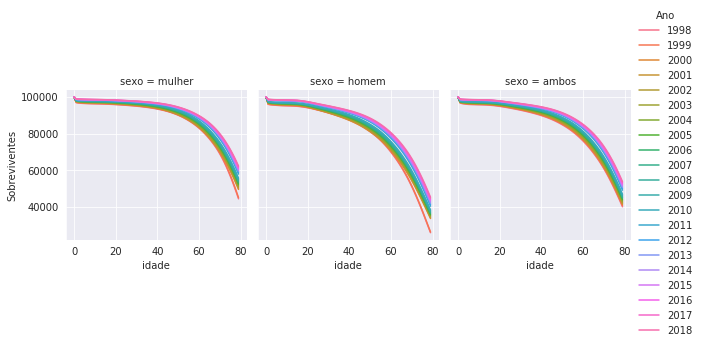

In [14]:
# grafico de sobreviventes - lx
sns.set_style("darkgrid")
graf = sns.FacetGrid(df_agregado, col="sexo", hue="Ano")
graf.map(sns.lineplot, "x", "lx")
graf.add_legend()
graf.set_xlabels("idade")
graf.set_ylabels("Sobreviventes")

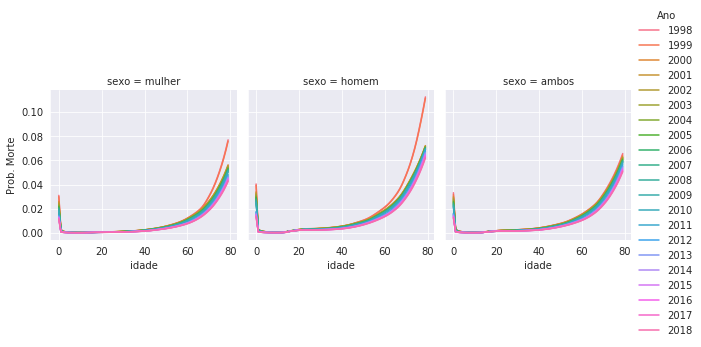

In [15]:
# grafico - probabilidade de morte
graf = sns.FacetGrid(df_agregado, col="sexo", hue="Ano")
graf.map(sns.lineplot, "x", "qx_prob")
graf.add_legend()
graf.set_xlabels("idade")
graf.set_ylabels("Prob. Morte")

[]

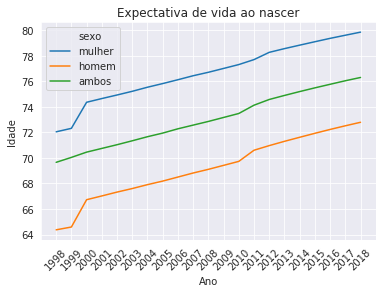

In [16]:
# Grafico de Expecativa de vida ao nascer
# Dataframe com x = 0
#sns.set() #reset o seaborn

df_agregado_0 = df_agregado.query("x == 0")
graf_0 = sns.lineplot('Ano', 'Ex', ci=None, data=df_agregado_0, hue="sexo")
graf_0.set_title("Expectativa de vida ao nascer")
graf_0.set_ylabel('Idade')
plt.xticks(rotation=45)
graf_0.plot()
# =============== GRAFICOS FIM =====================

In [12]:
# sorted --> subslistas classificadas pelo atributo "Ano" --> x[7]
df_to_lista = sorted(df_ambos.values.tolist(), key = lambda x: x[7])

In [13]:
# FUNÇÕES ATUARIAIS
def comutacao(FAj):
    qx_add = []
    qx_add_temp = []
    lx = []
    dx = []
    Lx = []
    Tx = []
    expx = []
    
    fx = 0.5
    #FAj = 100.0
    lx.append(100000.0)
    id_inicio = 0
    w = 120 # idade limite, onde não haverá vivos
    qx_add_temp.append(qx)
    qx_add = [*qx_add_temp[0]]
    
    for idade in range(id_inicio, 80):
        # primeiro passo
        dx.append(qx[idade]*lx[idade]/1000.0)  # dx = qx[idade]*lx[idade]/1000.0
        # segundo passo
        lx.append(lx[idade]-dx[idade])  # lx[idade+1] = lx[idade] - dx[idade]
    
    for idade in range(80, w):
        if lx[idade] != 0.0:
            # terceiro passo
            #lx[idade+2] = lx[idade+1]*(lx[idade+1]/(lx[idade]+FAj))
            lx.append(lx[idade]*(lx[idade]/(lx[idade-1]+FAj)))
        else:
            w = idade
            break        
    
    for idade in range(80, w):
        # quarto passo
        #dx[idade]=lx[idade]-lx[idade+1]
        dx.append(lx[idade]-lx[idade+1])
        # quinto passo
        # qx[idade] = dx[idade]/lx[idade]
        qx_add.append(dx[idade]/lx[idade]*1000.0)

    for idade in range(id_inicio, w):
        # sexto passo.
        # Lx[idade] = fx*lx[idade] + (1 - fx)*lx[idade+1]
        Lx.append(fx*lx[idade] + (1 - fx)*lx[idade+1])
    
    for idade in range(id_inicio, w):
        if lx[idade] != 0.0:
            # setimo passo
            # Tx = sum(Lx[idade:])
            Tx.append(sum(Lx[idade:]))
            # oitavo passo
            # exp = Tx[idade]/lx[idade]
            expx.append(Tx[idade]/lx[idade])
        else:
            break

    return idade, qx_add, dx, lx, Lx, Tx, expx

In [14]:
def comutacao_res(FAj):
    qx_add = []
    qx_add_temp = []
    lx = []
    dx = []
    Lx = []
    Tx = []
    expx = []
    
    fx = 0.5
    #FAj = 100.0
    lx.append(100000.0)
    id_inicio = 0
    w = 120 # idade limite, onde não haverá vivos
    qx_add_temp.append(qx)
    qx_add = [*qx_add_temp[0]]


    for idade in range(id_inicio, 80):
        # primeiro passo
        dx.append(qx[idade]*lx[idade]/1000.0)  # dx = qx[idade]*lx[idade]/1000.0
        # segundo passo
        lx.append(lx[idade]-dx[idade])  # lx[idade+1] = lx[idade] - dx[idade]
    
    for idade in range(80, w):
        if lx[idade] != 0.0:
            # terceiro passo
            #lx[idade+2] = lx[idade+1]*(lx[idade+1]/(lx[idade]+FAj))
            lx.append(lx[idade]*(lx[idade]/(lx[idade-1]+FAj)))
        else:
            w = idade
            break        
    
    for idade in range(80, w):
        # quarto passo
        #dx[idade]=lx[idade]-lx[idade+1]
        dx.append(lx[idade]-lx[idade+1])
        # quinto passo
        # qx[idade] = dx[idade]/lx[idade]
        qx_add.append(dx[idade]/lx[idade]*1000.0)

    for idade in range(id_inicio, w):
        # sexto passo.
        # Lx[idade] = fx*lx[idade] + (1 - fx)*lx[idade+1]
        Lx.append(fx*lx[idade] + (1 - fx)*lx[idade+1])
    
    for idade in range(id_inicio, w):
        if lx[idade] != 0.0:
            # setimo passo
            # Tx = sum(Lx[idade:])
            Tx.append(sum(Lx[idade:]))
            # oitavo passo
            # exp = Tx[idade]/lx[idade]
            expx.append(Tx[idade]/lx[idade])
        else:
            break

    erro = expx[79] - targetx
    return abs(erro)

In [15]:
# Função para unir as listas em linha
def unirSeries(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx

    return df1.join(df.drop(explode, 1), how='left')

### Interpolação para idades acima de 80 anos, inclusive.

#### Seguir os passos da Nota Técnica Atuarial sobre a Metodologia adotada pelo Ministério da Previdência Social na Extrapolação das Tábuas de Mortalidade IBGE para as idades acima de 80 anos
Fonte:https://www.example.com

In [16]:
dados = []
vetor_fatores = []
fatores_lista = []
vetor_dados = []
dados_lista = [] # np.empty((8,0)).tolist()
ano = 1997
inicio = 0
idade = []
ano_rept = []

for i in range(0,21): # Leitura de cada arquivo desde 1997
    ano += 1
    # intervalos de cada tabela de dados para cada ano
    fim = 81*(i+1)
    dados = df_to_lista[inicio:fim]
    inicio = fim
    FAj = 100.0
    
    # qx das tabelas do IBGE até 79 anos
    qx = [item[1] for item in dados][:-1]
    targetx = dados[79][6] # Expectativa de vida aos 80, na tabela do IBGE

    sol = optimize.minimize_scalar(comutacao_res) # , args=(FAj) se existissem mais outros parametros, usar args

    #sol.fun # erro / #sol.x # fator / #sol.sucess # sucesso /  #sol.nit # numero de iterações
    vetor_fatores = [str(ano), sol.x, sol.nit, sol.fun, sol.success]
    # aplicar append, pois é uma lista de uma lista de valores por vez
    fatores_lista.append(vetor_fatores) 

    x, qx_add, dx, lx, Lx, Tx, expx = comutacao(sol.x)

    idade = np.arange(0, x+1).tolist() #list(range(0, idade+1))
    ano_rept = np.repeat(ano, x+1).tolist()

    vetor_dados = [idade, qx_add, dx, lx[:-1], Lx, Tx, expx, ano_rept]
    # Aplicar extend para gravar as comutações, pois é uma lista de listas de valores
    dados_lista.append(vetor_dados)

In [17]:
# Salva no Dataframel
df_fatores = pd.DataFrame(fatores_lista, columns=['ano', 'fator_ajuste', 'num_interacoes', 'erro', 'converge'])
df_fatores

,ano,fator_ajuste,num_interacoes,erro,converge
0,1998,155.727751,24,4.857046e-09,True
1,1999,150.495103,21,8.019791e-09,True
2,2000,145.623480,22,7.490137e-09,True
3,2001,147.049430,24,2.547326e-09,True
4,2002,148.467122,23,9.924662e-09,True
5,2003,149.829493,23,1.290985e-10,True
6,2004,151.560570,22,9.204438e-09,True
7,2005,153.138136,24,2.205093e-09,True
8,2006,158.739519,22,3.944395e-09,True
9,2007,156.206425,21,5.525088e-09,True


In [18]:
df_temp = pd.DataFrame(dados_lista, columns=['idade', 'qx_mil', 'dx', 'lx', 'Lx', 'Tx', 'expx', 'ano'])
df_dados = unirSeries(df_temp,['idade', 'qx_mil', 'dx', 'lx', 'Lx', 'Tx', 'expx', 'ano'])
# df_dados.shape -> (2421,8). Desfeito vetor. Variaveis ao longo das linhas
df_dados = df_dados.reset_index(drop=True)

Text(0, 0.5, 'Sobreviventes')

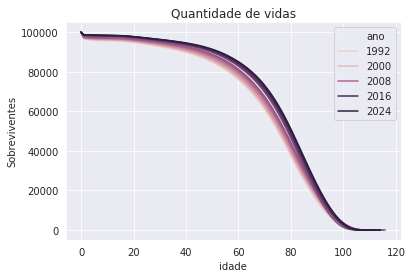

In [24]:
# ============== INICIO GRAFICOS =======================
# grafico de sobreviventes - lx
sns.set_style("darkgrid")
graf = sns.lineplot(data=df_dados, x="idade", y="lx", hue="ano")
graf.set_title("Quantidade de vidas")
#graf.set_xlabel("idade")
graf.set_ylabel("Sobreviventes")

Text(0, 0.5, 'Prob. Morte')

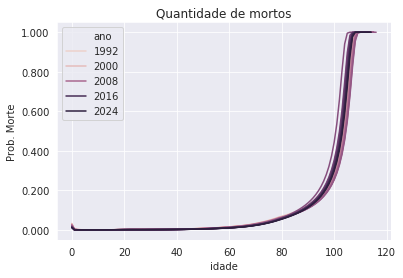

In [25]:
# grafico - probabilidade de morte
graf = sns.lineplot(data=df_dados, x="idade", y="qx_mil", hue="ano")
graf.set_title("Quantidade de mortos")
ylabels = ['{:,.3f}'.format(y) for y in graf.get_xticks()/100]
graf.set_yticklabels(ylabels)
graf.set_ylabel("Prob. Morte")

/home/doug/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


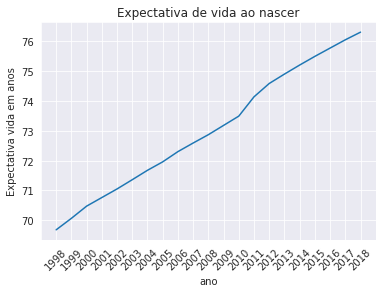

In [26]:
# Grafico de Expecativa de vida ao nascer
# Dataframe com x = 0
# eixo y:expectativa de vida ao nascer. idade=0. todos os anos (eixo x)

df_dadosx_0 = df_dados.query("idade == 0")
df_dadosx_0['ano'] = df_dadosx_0['ano'].astype(str)
graf_0 = sns.lineplot('ano', 'expx', ci=None, data=df_dadosx_0)
graf_0.set_title("Expectativa de vida ao nascer de 1998-2018")
graf_0.set_ylabel('Expectativa vida em anos')
plt.xticks(rotation=45)
plt.show()

/home/doug/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


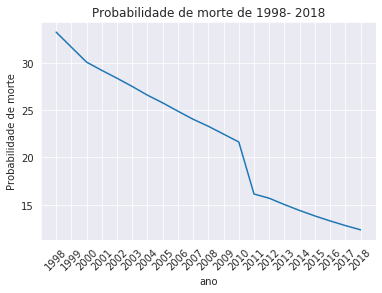

In [27]:
# verificar qx
df_dadosx_0 = df_dados.query("idade == 0")
df_dadosx_0['ano'] = df_dadosx_0['ano'].astype(str)
graf_0 = sns.lineplot('ano', 'qx_mil', ci=None, data=df_dadosx_0)
graf_0.set_title("Probabilidade de morte de 1998- 2018")
graf_0.set_ylabel('Probabilidade de morte')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Preparar o DataFrame para o LSTM
#lista_temp = df_temp.values
#lista_temp = df_temp.values.tolist()
#tamanho = [len(n) for n in lista_temp[)][1]] # tamanho de cada sublista
#menor = min(tamanho) # menor valor entre as sublistas
df_lstm = df_dados[['ano','idade','qx_mil', 'lx']].copy()
# deletar as linhas onde idade >=113 (menor tamanho)
indexNames = df_lstm[df_lstm['idade']>=113].index
df_lstm.drop(indexNames, inplace=True)
df_lstm = df_lstm.reset_index(drop=True)
df_lstm['xt'] = df_lstm['ano'].astype(str) + '_' + df_lstm['idade'].astype(str)
df_lstm['qx_prob'] = df_lstm['qx_mil']/1000.0

In [ ]:
# ====================== GRAFICO ========================
# # Gráfico temporal matplotlib. Seaborn demora muito a renderizar
#plt.style.use('seaborn-whitegrid')

#ax = plt.axes()
#ax.plot('xt','qx_prob', data=df_lstm)
#ax.set_title('Probabilidade de morte - Periodo 1999-2018')
#ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.set_xlabel('Ano_idade')
#ax.set_ylabel('Prob. Morte')
#ax.grid(True)

In [34]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(0.2))
    #model.add(Dense(y.shape[1]))
    #model.add(Dense(y.shape[1], activation='sigmoid', kernel_constraint=nonneg()))
    model.add(Dense(y.shape[1], activation='sigmoid'))
    #, activation='relu', kernel_constraint=unit_norm()
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=["accuracy"])
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model


def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]


def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts


def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted


def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted


def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

        
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()  


In [21]:
# load the dataset
series = df_lstm['qx_mil'].copy() 
series.head()

0    33.240000
1     3.568621
2     1.910081
3     1.393699
4     1.031110
Name: qx_mil, dtype: float64

In [22]:
len(series)

2373

2137/2137 [==============================] - 6s 3ms/step - loss: 4.2871e-04 - accuracy: 0.3210
t+1 RMSE: 14.666314
t+2 RMSE: 21.901734
t+3 RMSE: 29.443476
t+4 RMSE: 37.577216
t+5 RMSE: 45.472326
t+6 RMSE: 49.032318
t+7 RMSE: 54.543418
t+8 RMSE: 59.784497
t+9 RMSE: 69.338114
t+10 RMSE: 87.739788


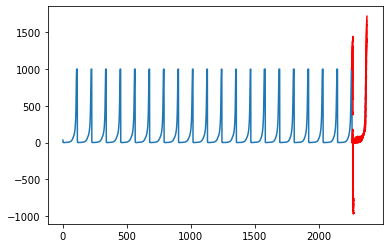


Tempo de processamento:
00:08:37.28



In [35]:
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 10 # 5 # 3 # número de anos adiante
n_test = 113 #791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 60 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

In [36]:
# verificar a saida do modelo:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 50)                   32800     
_________________________________________________________________
dropout_2 (Dropout)          (1, 50)                   0         
_________________________________________________________________
dense_3 (Dense)              (1, 10)                   510       
Total params: 33,310
Trainable params: 33,310
Non-trainable params: 0
_________________________________________________________________


In [71]:
pd.DataFrame(forecasts)

,0,1,2,3,4,5,6,7,8,9
0,1030.810305,1128.780085,1124.360763,1178.320624,1092.573592,1117.048966,1092.717088,1029.489846,955.234933,446.423654
1,1014.760034,1072.190503,1104.255998,1177.711961,1235.532411,1199.448815,1207.706279,1156.404162,512.940234,507.437094
2,1099.545387,1142.129601,1118.181324,1031.431721,1056.351711,1012.248310,970.567532,153.477200,117.123890,86.439772
3,27.810502,-12.294127,-177.329894,-93.837019,-99.030604,-170.567523,-1115.875994,-1177.683459,-1126.739951,-1176.826106
4,-30.042254,-143.170405,-113.367224,-228.241202,-277.221549,-1245.572684,-1299.581053,-1321.468251,-1326.602653,-1352.034572
...,...,...,...,...,...,...,...,...,...,...
108,718.497510,707.314521,674.616153,707.493239,767.804118,873.645953,984.646731,1092.340472,1183.911387,1242.523543
109,884.443522,897.160529,898.531752,950.853159,1036.167803,1147.496126,1257.300493,1335.612093,1357.943178,1330.297403
110,1011.803286,1052.802325,1092.057440,1182.257513,1287.371375,1402.275160,1488.184889,1513.413893,1477.470587,1429.746313
111,1042.189693,1099.094711,1165.354271,1261.743560,1361.420143,1440.369522,1443.140770,1407.557652,1357.312679,1317.459782


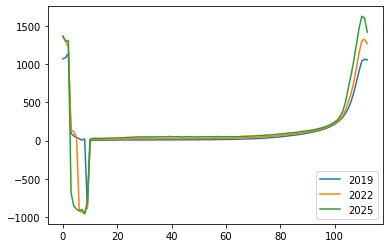

In [37]:
# Aqui foi com qx_mil
colunas = list(range(2019, 2029)) 
df_forecasts = pd.DataFrame(forecasts, columns=colunas)
df_forecasts[[2019, 2022, 2025]].plot()


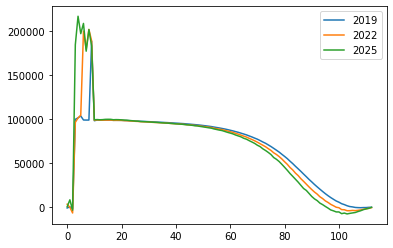

In [76]:
# Aqui foi com lx
colunas = list(range(2019, 2029)) 
df_forecasts = pd.DataFrame(forecasts, columns=colunas)
df_forecasts[[2019, 2022, 2025]].plot()

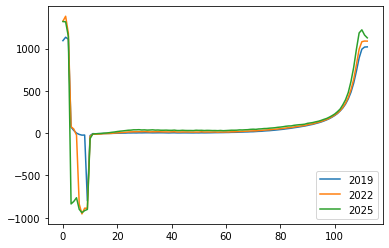

In [82]:
# Aqui foi com qx_prob e minmaxscaler = 0.05, 0.95
colunas = list(range(2019, 2029)) 
df_forecasts = pd.DataFrame(forecasts, columns=colunas)
df_forecasts[[2019, 2022, 2025]].plot()

In [83]:
from keras.constraints import nonneg

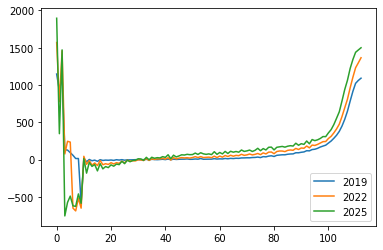

In [91]:
# com: model.add(Dense(y.shape[1], activation='sigmoid', kernel_constraint=nonneg()))
colunas = list(range(2019, 2029)) 
df_forecasts = pd.DataFrame(forecasts, columns=colunas)
df_forecasts[[2019, 2022, 2025]].plot()

In [68]:
# load the dataset
series = df_lstm['lx'].copy() 

1459/1459 [==============================] - 4s 3ms/step - loss: 7.9027e-04 - accuracy: 0.2234
t+1 RMSE: 5159.040566
t+2 RMSE: 3773.668344
t+3 RMSE: 3625.389047
t+4 RMSE: 9062.924517
t+5 RMSE: 9740.640072
t+6 RMSE: 7992.982484
t+7 RMSE: 17341.276012
t+8 RMSE: 9098.077001
t+9 RMSE: 961.581775
t+10 RMSE: 9650.703454


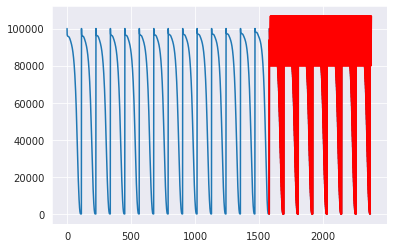


Tempo de processamento:
00:02:22.90



In [69]:
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 10 # 5 # 3 # número de anos adiante
n_test = 791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

In [70]:
# verificar a saida do modelo:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (1, 50)                   32800     
_________________________________________________________________
dense_13 (Dense)             (1, 10)                   510       
Total params: 33,310
Trainable params: 33,310
Non-trainable params: 0
_________________________________________________________________


1459/1459 [==============================] - 4s 3ms/step - loss: 7.0442e-04 - accuracy: 0.2700
t+1 RMSE: 687.013572
t+2 RMSE: 363.817343
t+3 RMSE: 11.873147
t+4 RMSE: 3474.287036
t+5 RMSE: 4304.095120
t+6 RMSE: 5046.426484
t+7 RMSE: 5325.497204
t+8 RMSE: 7640.730321
t+9 RMSE: 13505.369397
t+10 RMSE: 16007.558509


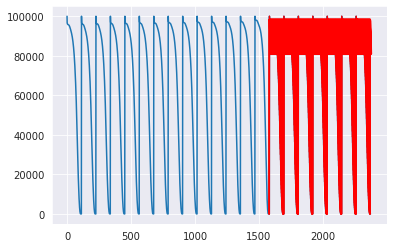


Tempo de processamento:
00:02:47.97



In [71]:
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 10 # 5 # 3 # número de anos adiante
n_test = 791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

1459/1459 [==============================] - 5s 3ms/step - loss: 5.2018e-04 - accuracy: 0.2824
t+1 RMSE: 675.474832
t+2 RMSE: 775.726816
t+3 RMSE: 925.413019
t+4 RMSE: 1311.237460
t+5 RMSE: 1973.100964
t+6 RMSE: 2646.474992
t+7 RMSE: 2144.517513
t+8 RMSE: 2087.198320
t+9 RMSE: 2298.795342
t+10 RMSE: 3047.768389


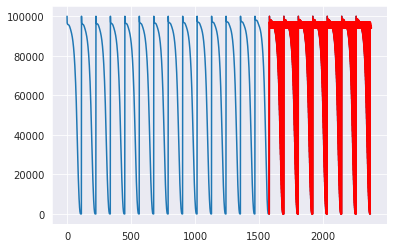


Tempo de processamento:
00:02:47.91



In [75]:
# Agora com scaler = (0,1)
# Depois com dropout = 0.2
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 10 # 5 # 3 # número de anos adiante
n_test = 791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print() 

In [76]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [77]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (1, 50)                   32800     
_________________________________________________________________
dropout (Dropout)            (1, 50)                   0         
_________________________________________________________________
dense_15 (Dense)             (1, 10)                   510       
Total params: 33,310
Trainable params: 33,310
Non-trainable params: 0
_________________________________________________________________


2146/2146 [==============================] - 7s 3ms/step - loss: 0.0085 - accuracy: 4.6598e-04
t+1 RMSE: 8.972551


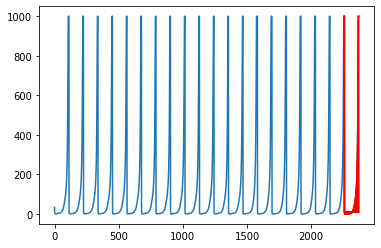


Tempo de processamento:
00:02:57.50



In [29]:
# load the dataset
series = df_lstm['qx_mil'].copy() 

# Agora com scaler = (-1,1)
# Depois com dropout = 0.2
# Com uma camada com a função sigmoid
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 1 # 5 # 3 # número de anos adiante
n_test = 113 #791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

In [30]:
pd.DataFrame(forecasts)

,0
0,10.081908
1,10.081908
2,10.081908
3,10.081908
4,10.081908
...,...
108,10.081908
109,10.081908
110,10.081908
111,10.081908


2146/2146 [==============================] - 5s 2ms/step - loss: 0.0031 - accuracy: 4.6598e-04
t+1 RMSE: 10.752210


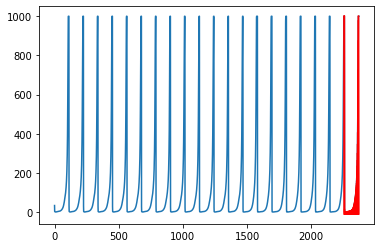


Tempo de processamento:
00:03:08.18



In [32]:
# load the dataset
series = df_lstm['qx_mil'].copy() 

# Agora com scaler = (0,1)
# Depois com dropout = 0.2
# Sem a camada com a função sigmoid
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 1 # 5 # 3 # número de anos adiante
n_test = 113 #791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

In [33]:
pd.DataFrame(forecasts)

,0
0,-9.642853
1,-9.642853
2,-9.642853
3,-9.642853
4,-9.642853
...,...
108,-9.642853
109,-9.642853
110,-9.642853
111,-9.642853


2146/2146 [==============================] - 6s 3ms/step - loss: 3.9972e-04 - accuracy: 4.6598e-04
t+1 RMSE: 79.126115


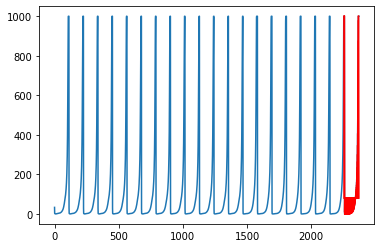


Tempo de processamento:
00:03:13.00



In [35]:
# load the dataset
series = df_lstm['qx_mil'].copy() 

# Agora com scaler = (0,1)
# Sem dropout = 0.2
# Sem a camada com a função sigmoid
# inicio do cronometro do processamento
start = time.time()
n_lag = 113 # 1 # 113 corresponde a uma tábua(idade de 0 a 113. No caso um ano.
n_seq = 1 # 5 # 3 # número de anos adiante
n_test = 113 #791 # Agora simulacao com 33 % teste = 791 (7 anos) / 113 => corresponde ao ano de 2018 como teste # 10
n_epochs = 30 #30 # 1500
n_batch = 1
n_neurons = 50 #50

#prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

#fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

#forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

#inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

#evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

#plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# fim do cronometro do processamento
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print()
print('Tempo de processamento:')
print('{:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))
print()

In [36]:
pd.DataFrame(forecasts)

,0
0,80.235472
1,80.235472
2,80.235472
3,80.235472
4,80.235472
...,...
108,80.235472
109,80.235472
110,80.235472
111,80.235472
